In [88]:
!nvidia-smi

Thu Dec 19 00:58:35 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.17                 Driver Version: 561.17         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8              2W /   28W |    1175MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [89]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import numpy as np

from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

from tqdm import trange, tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

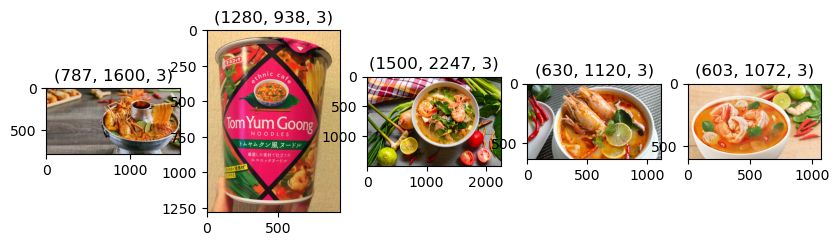

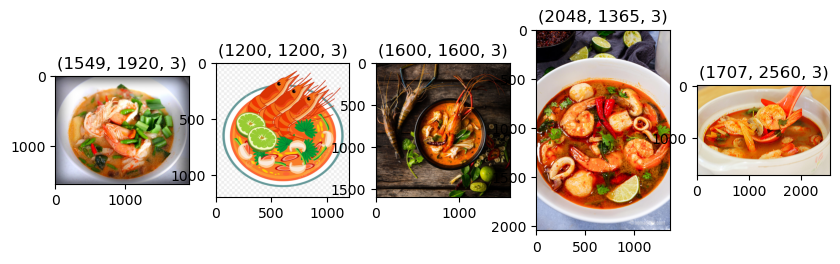

In [90]:
root_image = "n-shot/images"
food_names = os.listdir(root_image)

random_number = np.random.randint(1, len(food_names) + 1)
food = food_names[random_number]

rand_imgs = os.listdir(f"{root_image}/{food}")
image_path = f"n-shot/images/{food}"
image_list = [f"{image_path}/{imgs}" for imgs in rand_imgs]

for i,img in enumerate(image_list):
    img_arr = mpimg.imread(img)
    if i%5 ==0: fig, axs = plt.subplots(1,5, figsize=(10,10))
    _ = axs[i%5].imshow(img_arr)
    _ = axs[i%5].set_title(img_arr.shape)

In [91]:
train_classes_file = 'n-shot/meta/train_classes.txt'
test_classes_file = 'n-shot/meta/test_classes.txt'
root_image = "n-shot/images"
num_images_per_category = 10

train_name = []
with open(train_classes_file, mode='r', encoding='utf-8') as f:
    train_name = [line.strip() for line in f.readlines()]

test_name = []
with open(test_classes_file, mode='r', encoding='utf-8') as f:
    test_name = [line.strip() for line in f.readlines()]

In [92]:
transform = transforms.Compose([
    transforms.Resize([105, 105]),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) 
])

img_arr_train = torch.empty(len(train_name), num_images_per_category, 1, 105, 105)
img_arr_test = torch.empty(len(test_name), num_images_per_category, 1, 105, 105)

In [93]:
for i, food in enumerate(train_name):
    food_path = os.path.join(root_image, food)
    if os.path.exists(food_path):
        rand_imgs = os.listdir(food_path)
        for j, img in enumerate(rand_imgs[:num_images_per_category]):
            image_path = os.path.join(food_path, img)
            img_arr_train[i, j] = transform(Image.open(image_path))

for i, food in enumerate(test_name):
    food_path = os.path.join(root_image, food)
    if os.path.exists(food_path):
        rand_imgs = os.listdir(food_path)
        for j, img in enumerate(rand_imgs[:num_images_per_category]):
            image_path = os.path.join(food_path, img)
            img_arr_test[i, j] = transform(Image.open(image_path))

In [94]:
def show_random_class_image(img_arr, img_per_row=5, figsize=(10, 5)):
    rand_idx = np.random.randint(img_arr.size(0))
    num_images = img_arr.size(1)
    img_per_row = min(img_per_row, num_images)
    n_rows = int(np.ceil(num_images / img_per_row))

    fig, axs = plt.subplots(n_rows, img_per_row, figsize=figsize)
    axs = axs.flatten() if n_rows > 1 else [axs]

    for i in range(num_images):
        axs[i].imshow(img_arr[rand_idx, i].numpy().squeeze(0))

    plt.tight_layout()
    plt.show()

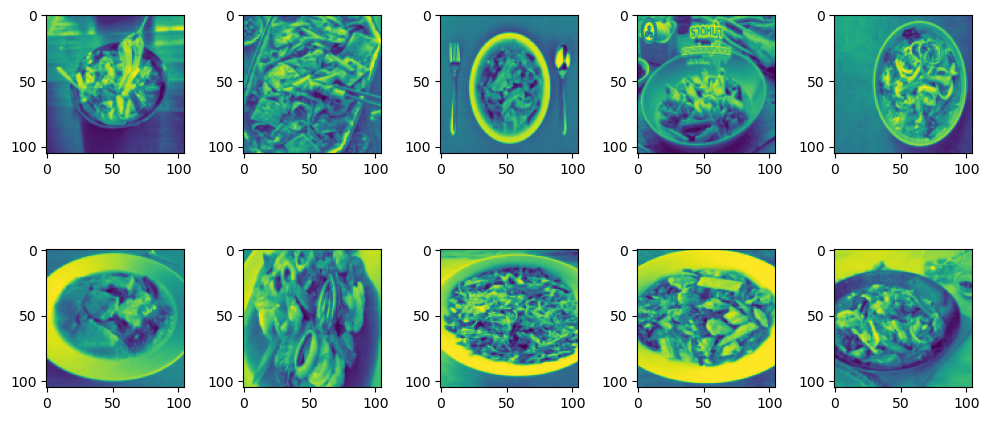

In [95]:
show_random_class_image(img_arr_train)

In [96]:
class TripletImageLoader:
    def __init__(self, img_arr_train, img_arr_val):
        self.img_arr_train = img_arr_train
        self.img_arr_val = img_arr_val
        self.n_classes, self.n_examples, self.n_ch, self.h, self.w = img_arr_train.shape
        self.n_val = img_arr_val.size(0)

    def get_batch(self, n):
        # Randomly pick `n` classes
        categories = np.random.choice(self.n_classes, size=n, replace=False)
        triplets = [torch.zeros((n, self.n_ch, self.h, self.w)) for _ in range(3)]

        for i in range(n):
            # Anchor and positive examples from the same class
            category = categories[i]
            idx_anchor, idx_pos = np.random.choice(self.n_examples, size=2, replace=False)
            triplets[0][i] = self.img_arr_train[category, idx_anchor]  # Anchor
            triplets[1][i] = self.img_arr_train[category, idx_pos]  # Positive
            
            # Negative example from a different class
            category_neg = (category + np.random.randint(1, self.n_classes)) % self.n_classes
            idx_neg = np.random.randint(0, self.n_examples)
            triplets[2][i] = self.img_arr_train[category_neg, idx_neg]  # Negative

        return triplets

    def make_oneshot_task(self, N):
        # Randomly select N categories
        categories = np.random.choice(self.n_val, size=N, replace=False)
        indices = np.random.randint(0, self.n_examples, size=N)
        true_cat = categories[0] 
        ex1, ex2 = np.random.choice(self.n_examples, size=2, replace=False)

        # Create the test image (repeated across the support set)
        test_image = torch.stack([self.img_arr_val[true_cat, ex1]] * N)

        # Create the support set, ensuring the first entry is the true category
        support_set = self.img_arr_val[categories, indices]
        support_set[0] = self.img_arr_val[true_cat, ex2]

        # Targets: first entry is 1 (true match), rest are 0
        targets = torch.zeros(N)
        targets[0] = 1

        return [test_image, support_set], targets

    def test_oneshot(self, model, N, k, device):
        model.eval()
        n_correct = 0

        for _ in range(k):
            inputs, targets = self.make_oneshot_task(N)
            inputs = [input.to(device) for input in inputs]
            targets = targets.to(device)

            dists = model.get_distance(*inputs).cpu().detach().numpy()
            if np.argmin(dists) == 0:
                n_correct += 1

        return (100 * n_correct) / k


In [97]:
triplet_dl = TripletImageLoader(img_arr_train, img_arr_test)

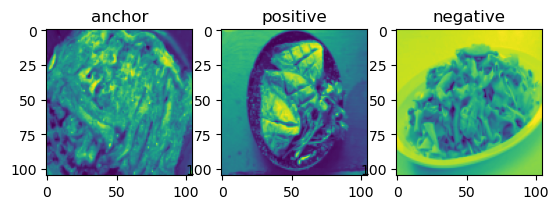

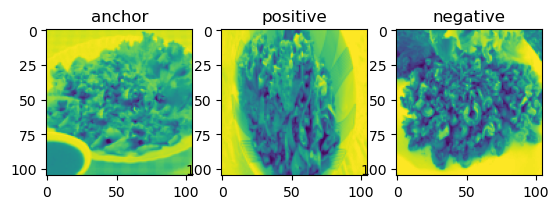

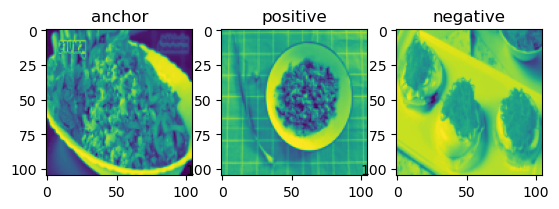

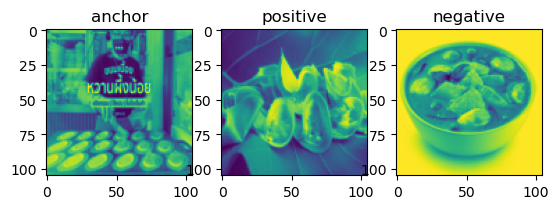

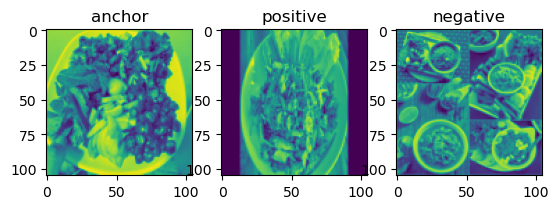

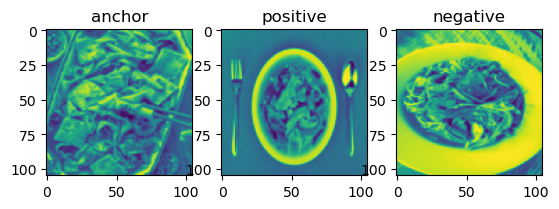

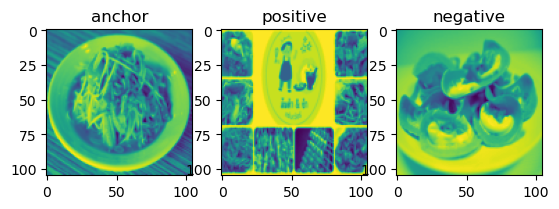

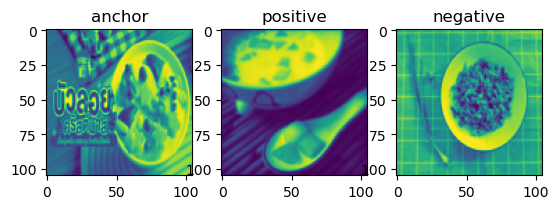

In [98]:
triplets = triplet_dl.get_batch(8)
for anchor, pos, neg in zip(triplets[0], triplets[1], triplets[2]):
    fig, axs = plt.subplots(1,3)
    _=axs[0].imshow(anchor.numpy().squeeze(0))
    _=axs[0].set_title('anchor')
    _=axs[1].imshow(pos.numpy().squeeze(0))
    _=axs[1].set_title('positive')
    _=axs[2].imshow(neg.numpy().squeeze(0))
    _=axs[2].set_title('negative')
    plt.show()

In [99]:
def show_oneshot_task(dataloader, N, n_ch=1, img_per_row=5, figsize=(10, 5)):
    pairs, targets = dataloader.make_oneshot_task(N)

    # Display the Test set
    print('Test Image:')
    plt.figure(figsize=(5, 5))
    plt.imshow(pairs[0][0].numpy().squeeze(0))
    plt.show()

    # Display the support set
    print('Support Set:')
    img_per_row = min(img_per_row, N)
    n_rows = int(np.ceil(N / img_per_row))

    fig, axs = plt.subplots(n_rows, img_per_row, figsize=figsize)
    axs = axs.flatten() if n_rows > 1 else [axs]
    for i in range(N):
        axs[i].imshow(pairs[1][i].numpy().squeeze(0))
        axs[i].set_title(f"Support {i}")

    plt.tight_layout()
    plt.show()

Test Image:


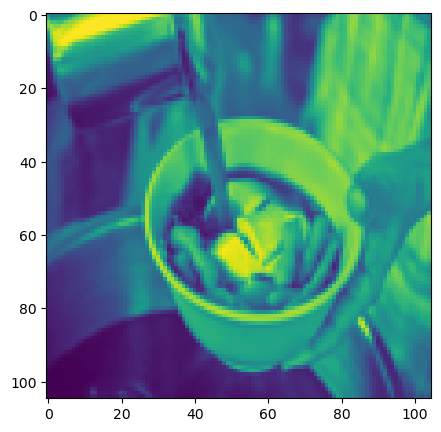

Support Set:


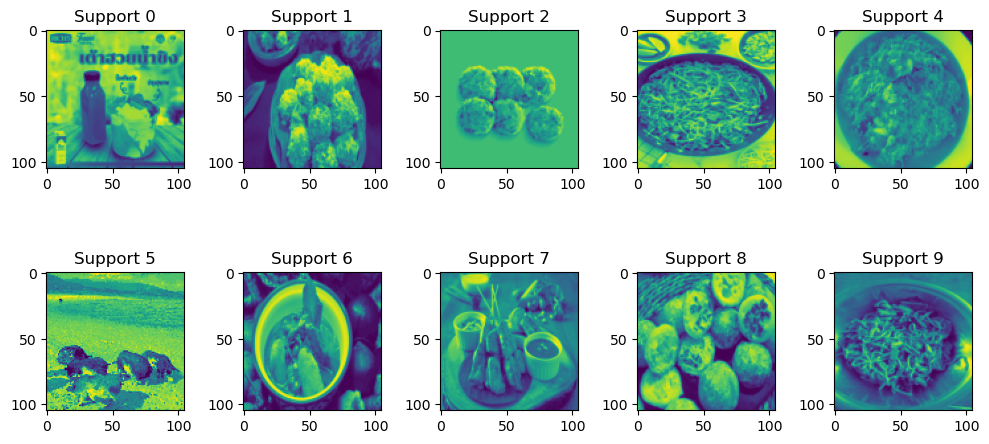

In [100]:
show_oneshot_task(triplet_dl, N=10, n_ch=1)

In [101]:
def get_fc_layers(fc_sizes, ps):
    fc_layers_list = []
    for ni, nf, p in zip(fc_sizes[:-1], fc_sizes[1:], ps):
        fc_layers_list.append(nn.Linear(ni, nf))
        fc_layers_list.append(nn.ReLU(inplace=True))
        fc_layers_list.append(nn.BatchNorm1d(nf))
        fc_layers_list.append(nn.Dropout(p=p))
    return nn.Sequential(*fc_layers_list)

class Resnet34FeatureExtractor(nn.Module):
    def __init__(self, n_ch=3, feat_dim=128, pretrained=True):
        super().__init__()
        assert n_ch in [1, 3], "Input channels must be 1 or 3."

        self.feat_dim = feat_dim

        resnet34 = models.resnet34(pretrained=pretrained)
        resnet34.conv1 = nn.Conv2d(n_ch, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        self.body = nn.Sequential(*list(resnet34.children())[:-1])
        self.dense = get_fc_layers(fc_sizes=[512, 1024, 512, feat_dim], ps=[0.5, 0.5, 0.5])

    def forward(self, input):
        output = self.body(input)
        output = torch.flatten(output, 1)
        output = self.dense(output)
        return output

class TripletNet(nn.Module):
    def __init__(self, feature_extractor_module: nn.Module):
        super().__init__()
        self.feature_extractor = feature_extractor_module

    def get_distance(self, img1, img2):
        img1_feat = self.feature_extractor(img1)
        img2_feat = self.feature_extractor(img2)
        return F.pairwise_distance(img1_feat, img2_feat, p=2.0, keepdim=True)

    def forward(self, input):
        anchor, pos, neg = input
        p_dist = self.get_distance(anchor, pos)
        n_dist = self.get_distance(anchor, neg)
        return (p_dist, n_dist)

class TripletLoss(nn.Module):
    def __init__(self, alpha=0.2):
        super().__init__()
        self.alpha = alpha

    def forward(self, input):
        p_dist, n_dist = input
        return torch.mean(torch.max(p_dist - n_dist + self.alpha, torch.zeros_like(p_dist)))


In [102]:
class CancelTrainException(Exception): pass

class LRFinderTriplet:
    def __init__(self, model, data_loader, bs, loss_func, opt, lr_range, max_iter):
        self.lrs = []
        self.losses = []
        self.model = model
        self.data_loader = data_loader
        self.bs = bs
        self.loss_func = loss_func
        self.opt = opt
        self.lr_range = lr_range
        self.max_iter = max_iter

    def run(self):
        best_loss = 1e9 
        for i in trange(self.max_iter):
            pos = i / self.max_iter
            lr = self.lr_range[0] * (self.lr_range[1] / self.lr_range[0]) ** pos

            for pg in self.opt.param_groups:
                pg['lr'] = lr

            xb = self.data_loader.get_batch(self.bs)
            xb = [x.to(device) for x in xb]
            loss = self.loss_func(self.model(xb))

            # Backpropagate and optimize
            loss.backward()
            self.opt.step()
            self.opt.zero_grad()

            #early stopping
            if loss.item() > best_loss * 10:
                raise CancelTrainException()

            # Update the best loss
            if loss.item() < best_loss:
                best_loss = loss.item()

            # Append the current learning rate and loss
            self.lrs.append(lr)
            self.losses.append(loss.item())

    def plot_lr(self):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')
        plt.xlabel('Learning Rate (log scale)')
        plt.ylabel('Loss')
        plt.title('Learning Rate Finder')
        plt.show()

In [111]:
def train_n_batch_triplet(n, data_loader, loss_func, model, opt, bs, eval_every, loss_every, N_way, n_val, model_path, device):
    best_acc = 0
    model.train()

    for i in tqdm(range(n)):
        xb = data_loader.get_batch(bs)
        xb = [x.to(device) for x in xb]

        loss = loss_func(model(xb))

        # Backpropagation
        loss.backward()
        opt.step()
        opt.zero_grad()

        if i % eval_every == 0 and i != 0:
            model.eval()
            val_acc = data_loader.test_oneshot(model, N_way, n_val, device)
            print(f"Validation accuracy on {N_way} supports of total {n_val} set: {val_acc:.2f}%")

            if val_acc >= best_acc:
                print("Saving model with improved accuracy.")
                torch.save(model.state_dict(), model_path)
                best_acc = val_acc
            model.train()

        if i % loss_every == 0:
            print(f"Iteration {i}, Training Loss: {loss.item():.2f}")


In [109]:
triplet_dl = TripletImageLoader(img_arr_train, img_arr_test)
model = TripletNet(feature_extractor_module=Resnet34FeatureExtractor(n_ch= 1, feat_dim= 128, pretrained= False)).to(device)
loss_func = TripletLoss(.8)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
lr_finder = LRFinderTriplet(model=model, data_loader=triplet_dl, bs=8, loss_func=loss_func, opt=optimizer,
                     lr_range=[1e-7,1], max_iter=500)
lr_finder.run()

c:\Users\Auto\anaconda3\envs\Food\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Auto\anaconda3\envs\Food\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
 41%|████▏     | 207/500 [00:36<00:52,  5.62it/s]


KeyboardInterrupt: 

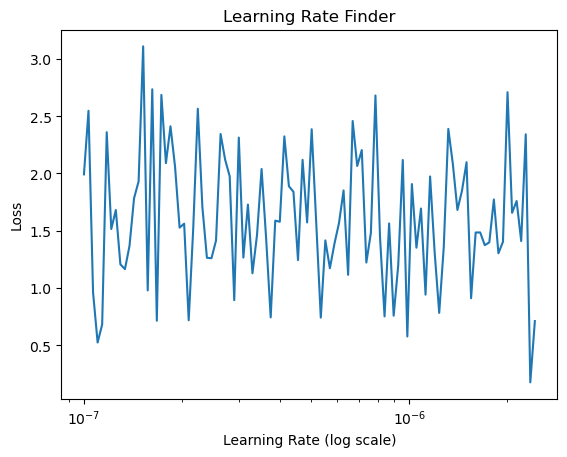

In [105]:
lr_finder.plot_lr()

In [112]:
triplet_dl = TripletImageLoader(img_arr_train,img_arr_test)
model = TripletNet(feature_extractor_module=Resnet34FeatureExtractor(n_ch= 1, feat_dim=128, pretrained= False)).to(device)
loss_func = TripletLoss(.8)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-6)

train_n_batch_triplet(n=10_000, data_loader=triplet_dl, loss_func=loss_func, model=model, opt=optimizer, bs=8,
              eval_every=100, loss_every=50, N_way=10, n_val=100, model_path='model.pt', device= device)

  0%|          | 2/10000 [00:00<35:47,  4.66it/s]

Iteration 0, Training Loss: 1.28


  1%|          | 52/10000 [00:07<24:23,  6.80it/s]

Iteration 50, Training Loss: 1.75


  1%|          | 100/10000 [00:14<29:53,  5.52it/s]

Validation accuracy on 10 supports of total 100 set: 8.00%
Saving model with improved accuracy.


  1%|          | 102/10000 [00:18<2:14:25,  1.23it/s]

Iteration 100, Training Loss: 1.69


  2%|▏         | 152/10000 [00:25<25:55,  6.33it/s]  

Iteration 150, Training Loss: 1.98


  2%|▏         | 201/10000 [00:37<3:21:25,  1.23s/it]

Validation accuracy on 10 supports of total 100 set: 8.00%
Saving model with improved accuracy.
Iteration 200, Training Loss: 0.87


  3%|▎         | 251/10000 [00:45<28:30,  5.70it/s]  

Iteration 250, Training Loss: 0.98


  3%|▎         | 301/10000 [00:58<3:18:54,  1.23s/it]

Validation accuracy on 10 supports of total 100 set: 11.00%
Saving model with improved accuracy.
Iteration 300, Training Loss: 2.11


  4%|▎         | 352/10000 [01:07<27:40,  5.81it/s]  

Iteration 350, Training Loss: 2.02


  4%|▍         | 402/10000 [01:20<2:37:11,  1.02it/s]

Validation accuracy on 10 supports of total 100 set: 10.00%
Iteration 400, Training Loss: 2.08


  5%|▍         | 452/10000 [01:27<27:36,  5.76it/s]  

Iteration 450, Training Loss: 2.09


  5%|▌         | 501/10000 [01:39<2:44:49,  1.04s/it]

Validation accuracy on 10 supports of total 100 set: 9.00%
Iteration 500, Training Loss: 1.61


  6%|▌         | 552/10000 [01:48<30:19,  5.19it/s]  

Iteration 550, Training Loss: 2.07


  6%|▌         | 601/10000 [02:00<3:14:44,  1.24s/it]

Validation accuracy on 10 supports of total 100 set: 14.00%
Saving model with improved accuracy.
Iteration 600, Training Loss: 0.53


  7%|▋         | 652/10000 [02:10<28:47,  5.41it/s]  

Iteration 650, Training Loss: 3.03


  7%|▋         | 702/10000 [02:24<2:49:58,  1.10s/it]

Validation accuracy on 10 supports of total 100 set: 9.00%
Iteration 700, Training Loss: 1.36


  8%|▊         | 752/10000 [02:31<22:26,  6.87it/s]  

Iteration 750, Training Loss: 0.89


  8%|▊         | 802/10000 [02:42<2:06:20,  1.21it/s]

Validation accuracy on 10 supports of total 100 set: 8.00%
Iteration 800, Training Loss: 1.34


  9%|▊         | 852/10000 [02:50<24:34,  6.20it/s]  

Iteration 850, Training Loss: 1.15


  9%|▉         | 902/10000 [03:03<2:33:35,  1.01s/it]

Validation accuracy on 10 supports of total 100 set: 11.00%
Iteration 900, Training Loss: 2.28


 10%|▉         | 952/10000 [03:11<26:04,  5.78it/s]  

Iteration 950, Training Loss: 1.70


 10%|█         | 1002/10000 [03:24<2:24:11,  1.04it/s]

Validation accuracy on 10 supports of total 100 set: 12.00%
Iteration 1000, Training Loss: 1.73


 11%|█         | 1052/10000 [03:32<21:43,  6.86it/s]  

Iteration 1050, Training Loss: 1.80


 11%|█         | 1102/10000 [03:42<1:49:51,  1.35it/s]

Validation accuracy on 10 supports of total 100 set: 12.00%
Iteration 1100, Training Loss: 1.62


 12%|█▏        | 1152/10000 [03:50<22:48,  6.47it/s]  

Iteration 1150, Training Loss: 3.04


 12%|█▏        | 1202/10000 [04:01<2:06:17,  1.16it/s]

Validation accuracy on 10 supports of total 100 set: 9.00%
Iteration 1200, Training Loss: 1.53


 13%|█▎        | 1252/10000 [04:10<23:43,  6.14it/s]  

Iteration 1250, Training Loss: 1.53


 13%|█▎        | 1301/10000 [04:21<2:43:11,  1.13s/it]

Validation accuracy on 10 supports of total 100 set: 13.00%
Iteration 1300, Training Loss: 1.62


 14%|█▎        | 1351/10000 [05:14<32:10,  4.48it/s]   

Iteration 1350, Training Loss: 1.58


 14%|█▍        | 1403/10000 [05:23<44:59,  3.18it/s]  

Validation accuracy on 10 supports of total 100 set: 9.00%
Iteration 1400, Training Loss: 1.82


 15%|█▍        | 1453/10000 [05:28<14:25,  9.87it/s]

Iteration 1450, Training Loss: 2.37


 15%|█▌        | 1503/10000 [05:35<48:46,  2.90it/s]  

Validation accuracy on 10 supports of total 100 set: 8.00%
Iteration 1500, Training Loss: 2.12


 16%|█▌        | 1553/10000 [05:40<14:34,  9.66it/s]

Iteration 1550, Training Loss: 1.15


 16%|█▌        | 1601/10000 [05:47<1:14:59,  1.87it/s]

Validation accuracy on 10 supports of total 100 set: 14.00%
Saving model with improved accuracy.
Iteration 1600, Training Loss: 2.44


 17%|█▋        | 1652/10000 [05:53<16:22,  8.50it/s]  

Iteration 1650, Training Loss: 0.96


 17%|█▋        | 1703/10000 [06:00<42:17,  3.27it/s]

Validation accuracy on 10 supports of total 100 set: 9.00%
Iteration 1700, Training Loss: 1.34


 18%|█▊        | 1753/10000 [06:06<15:01,  9.15it/s]

Iteration 1750, Training Loss: 1.26


 18%|█▊        | 1802/10000 [06:13<1:09:14,  1.97it/s]

Validation accuracy on 10 supports of total 100 set: 8.00%
Iteration 1800, Training Loss: 0.42


 19%|█▊        | 1853/10000 [06:19<14:25,  9.42it/s]  

Iteration 1850, Training Loss: 0.62


 19%|█▉        | 1902/10000 [06:27<1:10:16,  1.92it/s]

Validation accuracy on 10 supports of total 100 set: 11.00%
Iteration 1900, Training Loss: 1.61


 20%|█▉        | 1951/10000 [06:33<15:44,  8.53it/s]  

Iteration 1950, Training Loss: 3.46


 20%|██        | 2002/10000 [06:40<57:48,  2.31it/s]  

Validation accuracy on 10 supports of total 100 set: 9.00%
Iteration 2000, Training Loss: 1.35


 21%|██        | 2052/10000 [06:46<15:13,  8.70it/s]

Iteration 2050, Training Loss: 2.09


 21%|██        | 2101/10000 [06:53<1:11:51,  1.83it/s]

Validation accuracy on 10 supports of total 100 set: 15.00%
Saving model with improved accuracy.
Iteration 2100, Training Loss: 2.06


 22%|██▏       | 2153/10000 [06:59<13:34,  9.63it/s]  

Iteration 2150, Training Loss: 1.36


 22%|██▏       | 2202/10000 [07:06<51:02,  2.55it/s]  

Validation accuracy on 10 supports of total 100 set: 13.00%
Iteration 2200, Training Loss: 0.82


 23%|██▎       | 2252/10000 [07:11<14:54,  8.66it/s]

Iteration 2250, Training Loss: 1.18


 23%|██▎       | 2302/10000 [07:19<50:41,  2.53it/s]  

Validation accuracy on 10 supports of total 100 set: 12.00%
Iteration 2300, Training Loss: 1.86


 24%|██▎       | 2352/10000 [07:24<13:41,  9.31it/s]

Iteration 2350, Training Loss: 0.79


 24%|██▍       | 2402/10000 [07:32<1:03:01,  2.01it/s]

Validation accuracy on 10 supports of total 100 set: 13.00%
Iteration 2400, Training Loss: 2.25


 25%|██▍       | 2452/10000 [07:37<14:28,  8.69it/s]  

Iteration 2450, Training Loss: 1.24


 25%|██▌       | 2501/10000 [07:45<1:00:54,  2.05it/s]

Validation accuracy on 10 supports of total 100 set: 6.00%
Iteration 2500, Training Loss: 1.31


 26%|██▌       | 2551/10000 [07:51<13:35,  9.14it/s]  

Iteration 2550, Training Loss: 2.08


 26%|██▌       | 2601/10000 [07:58<1:23:26,  1.48it/s]

Validation accuracy on 10 supports of total 100 set: 15.00%
Saving model with improved accuracy.
Iteration 2600, Training Loss: 1.22


 27%|██▋       | 2653/10000 [08:04<12:26,  9.85it/s]  

Iteration 2650, Training Loss: 1.06


 27%|██▋       | 2703/10000 [08:11<45:09,  2.69it/s]  

Validation accuracy on 10 supports of total 100 set: 7.00%
Iteration 2700, Training Loss: 1.15


 28%|██▊       | 2752/10000 [08:17<15:11,  7.95it/s]

Iteration 2750, Training Loss: 1.86


 28%|██▊       | 2802/10000 [08:25<1:01:11,  1.96it/s]

Validation accuracy on 10 supports of total 100 set: 7.00%
Iteration 2800, Training Loss: 2.21


 29%|██▊       | 2853/10000 [08:31<12:31,  9.50it/s]  

Iteration 2850, Training Loss: 1.07


 29%|██▉       | 2902/10000 [08:38<54:27,  2.17it/s]  

Validation accuracy on 10 supports of total 100 set: 8.00%
Iteration 2900, Training Loss: 2.09


 30%|██▉       | 2953/10000 [08:43<12:53,  9.11it/s]

Iteration 2950, Training Loss: 2.76


 30%|███       | 3002/10000 [08:51<54:23,  2.14it/s]  

Validation accuracy on 10 supports of total 100 set: 11.00%
Iteration 3000, Training Loss: 1.34


 31%|███       | 3053/10000 [08:57<12:18,  9.41it/s]

Iteration 3050, Training Loss: 1.24


 31%|███       | 3102/10000 [09:04<1:03:46,  1.80it/s]

Validation accuracy on 10 supports of total 100 set: 9.00%
Iteration 3100, Training Loss: 0.40


 32%|███▏      | 3153/10000 [09:10<12:36,  9.05it/s]  

Iteration 3150, Training Loss: 1.28


 32%|███▏      | 3201/10000 [09:17<1:12:35,  1.56it/s]

Validation accuracy on 10 supports of total 100 set: 15.00%
Saving model with improved accuracy.
Iteration 3200, Training Loss: 1.46


 33%|███▎      | 3253/10000 [09:23<12:56,  8.69it/s]  

Iteration 3250, Training Loss: 1.79


 33%|███▎      | 3302/10000 [09:31<56:48,  1.97it/s]  

Validation accuracy on 10 supports of total 100 set: 11.00%
Iteration 3300, Training Loss: 0.92


 34%|███▎      | 3353/10000 [09:36<11:34,  9.57it/s]

Iteration 3350, Training Loss: 0.73


 34%|███▍      | 3402/10000 [09:44<57:18,  1.92it/s]  

Validation accuracy on 10 supports of total 100 set: 7.00%
Iteration 3400, Training Loss: 2.77


 35%|███▍      | 3452/10000 [09:49<12:04,  9.04it/s]

Iteration 3450, Training Loss: 0.99


 35%|███▌      | 3502/10000 [09:57<53:38,  2.02it/s]  

Validation accuracy on 10 supports of total 100 set: 7.00%
Iteration 3500, Training Loss: 2.14


 36%|███▌      | 3551/10000 [10:03<12:33,  8.56it/s]

Iteration 3550, Training Loss: 2.44


 36%|███▌      | 3601/10000 [10:10<1:18:03,  1.37it/s]

Validation accuracy on 10 supports of total 100 set: 15.00%
Saving model with improved accuracy.
Iteration 3600, Training Loss: 1.82


 37%|███▋      | 3652/10000 [10:16<12:11,  8.68it/s]  

Iteration 3650, Training Loss: 1.38


 37%|███▋      | 3702/10000 [10:24<47:44,  2.20it/s]

Validation accuracy on 10 supports of total 100 set: 11.00%
Iteration 3700, Training Loss: 1.20


 38%|███▊      | 3752/10000 [10:29<12:01,  8.67it/s]

Iteration 3750, Training Loss: 2.00


 38%|███▊      | 3802/10000 [10:37<47:28,  2.18it/s]

Validation accuracy on 10 supports of total 100 set: 11.00%
Iteration 3800, Training Loss: 0.94


 39%|███▊      | 3851/10000 [10:43<12:04,  8.48it/s]

Iteration 3850, Training Loss: 1.16


 39%|███▉      | 3902/10000 [10:50<52:38,  1.93it/s]  

Validation accuracy on 10 supports of total 100 set: 9.00%
Iteration 3900, Training Loss: 0.64


 40%|███▉      | 3951/10000 [10:56<11:48,  8.54it/s]

Iteration 3950, Training Loss: 1.58


 40%|████      | 4002/10000 [11:04<50:06,  1.99it/s]  

Validation accuracy on 10 supports of total 100 set: 10.00%
Iteration 4000, Training Loss: 0.71


 41%|████      | 4052/10000 [11:09<11:50,  8.38it/s]

Iteration 4050, Training Loss: 2.55


 41%|████      | 4102/10000 [11:17<49:39,  1.98it/s]  

Validation accuracy on 10 supports of total 100 set: 8.00%
Iteration 4100, Training Loss: 1.78


 42%|████▏     | 4152/10000 [11:23<10:49,  9.00it/s]

Iteration 4150, Training Loss: 0.56


 42%|████▏     | 4202/10000 [11:30<50:45,  1.90it/s]  

Validation accuracy on 10 supports of total 100 set: 10.00%
Iteration 4200, Training Loss: 1.61


 43%|████▎     | 4253/10000 [11:36<10:49,  8.85it/s]

Iteration 4250, Training Loss: 1.02


 43%|████▎     | 4302/10000 [11:44<38:48,  2.45it/s]

Validation accuracy on 10 supports of total 100 set: 12.00%
Iteration 4300, Training Loss: 0.14


 44%|████▎     | 4353/10000 [11:50<09:59,  9.41it/s]

Iteration 4350, Training Loss: 1.83


 44%|████▍     | 4402/10000 [11:57<46:44,  2.00it/s]  

Validation accuracy on 10 supports of total 100 set: 11.00%
Iteration 4400, Training Loss: 1.76


 45%|████▍     | 4453/10000 [12:03<10:24,  8.88it/s]

Iteration 4450, Training Loss: 1.24


 45%|████▌     | 4503/10000 [12:11<39:10,  2.34it/s]  

Validation accuracy on 10 supports of total 100 set: 6.00%
Iteration 4500, Training Loss: 2.22


 46%|████▌     | 4553/10000 [12:17<09:58,  9.10it/s]

Iteration 4550, Training Loss: 2.03


 46%|████▌     | 4602/10000 [12:24<46:18,  1.94it/s]  

Validation accuracy on 10 supports of total 100 set: 4.00%
Iteration 4600, Training Loss: 1.58


 47%|████▋     | 4652/10000 [12:30<10:32,  8.45it/s]

Iteration 4650, Training Loss: 1.39


 47%|████▋     | 4702/10000 [12:37<39:40,  2.23it/s]

Validation accuracy on 10 supports of total 100 set: 9.00%
Iteration 4700, Training Loss: 1.38


 48%|████▊     | 4751/10000 [12:43<10:07,  8.64it/s]

Iteration 4750, Training Loss: 1.64


 48%|████▊     | 4802/10000 [12:51<44:14,  1.96it/s]

Validation accuracy on 10 supports of total 100 set: 10.00%
Iteration 4800, Training Loss: 1.77


 49%|████▊     | 4853/10000 [12:57<09:22,  9.15it/s]

Iteration 4850, Training Loss: 1.05


 49%|████▉     | 4902/10000 [13:04<39:47,  2.14it/s]

Validation accuracy on 10 supports of total 100 set: 9.00%
Iteration 4900, Training Loss: 3.20


 50%|████▉     | 4952/10000 [13:10<09:59,  8.42it/s]

Iteration 4950, Training Loss: 2.36


 50%|█████     | 5002/10000 [13:18<42:30,  1.96it/s]

Validation accuracy on 10 supports of total 100 set: 7.00%
Iteration 5000, Training Loss: 1.31


 51%|█████     | 5051/10000 [13:23<09:51,  8.37it/s]

Iteration 5050, Training Loss: 1.16


 51%|█████     | 5102/10000 [13:32<45:21,  1.80it/s]

Validation accuracy on 10 supports of total 100 set: 13.00%
Iteration 5100, Training Loss: 1.33


 52%|█████▏    | 5152/10000 [13:38<10:58,  7.36it/s]

Iteration 5150, Training Loss: 2.67


 52%|█████▏    | 5202/10000 [13:45<40:21,  1.98it/s]

Validation accuracy on 10 supports of total 100 set: 9.00%
Iteration 5200, Training Loss: 1.80


 53%|█████▎    | 5251/10000 [13:51<08:54,  8.88it/s]

Iteration 5250, Training Loss: 0.50


 53%|█████▎    | 5302/10000 [13:59<40:39,  1.93it/s]

Validation accuracy on 10 supports of total 100 set: 12.00%
Iteration 5300, Training Loss: 1.96


 54%|█████▎    | 5353/10000 [14:05<08:31,  9.08it/s]

Iteration 5350, Training Loss: 1.65


 54%|█████▍    | 5402/10000 [14:12<39:44,  1.93it/s]

Validation accuracy on 10 supports of total 100 set: 14.00%
Iteration 5400, Training Loss: 0.72


 55%|█████▍    | 5453/10000 [14:18<08:21,  9.07it/s]

Iteration 5450, Training Loss: 1.14


 55%|█████▌    | 5502/10000 [14:26<39:45,  1.89it/s]

Validation accuracy on 10 supports of total 100 set: 13.00%
Iteration 5500, Training Loss: 1.31


 56%|█████▌    | 5551/10000 [14:32<08:36,  8.62it/s]

Iteration 5550, Training Loss: 2.04


 56%|█████▌    | 5602/10000 [14:40<39:46,  1.84it/s]

Validation accuracy on 10 supports of total 100 set: 11.00%
Iteration 5600, Training Loss: 0.98


 57%|█████▋    | 5652/10000 [14:45<08:55,  8.12it/s]

Iteration 5650, Training Loss: 1.59


 57%|█████▋    | 5701/10000 [15:06<2:45:02,  2.30s/it]

Validation accuracy on 10 supports of total 100 set: 10.00%
Iteration 5700, Training Loss: 1.22


 58%|█████▊    | 5751/10000 [15:21<21:14,  3.33it/s]  

Iteration 5750, Training Loss: 2.24


 58%|█████▊    | 5801/10000 [15:41<2:14:07,  1.92s/it]

Validation accuracy on 10 supports of total 100 set: 12.00%
Iteration 5800, Training Loss: 2.49


 59%|█████▊    | 5851/10000 [15:56<19:27,  3.55it/s]  

Iteration 5850, Training Loss: 2.99


 59%|█████▉    | 5901/10000 [16:16<2:08:05,  1.87s/it]

Validation accuracy on 10 supports of total 100 set: 13.00%
Iteration 5900, Training Loss: 1.55


 60%|█████▉    | 5951/10000 [16:32<26:04,  2.59it/s]  

Iteration 5950, Training Loss: 1.73


 60%|██████    | 6000/10000 [16:50<19:15,  3.46it/s]

Validation accuracy on 10 supports of total 100 set: 15.00%
Saving model with improved accuracy.


 60%|██████    | 6001/10000 [16:56<2:14:04,  2.01s/it]

Iteration 6000, Training Loss: 0.44


 61%|██████    | 6051/10000 [17:11<18:29,  3.56it/s]  

Iteration 6050, Training Loss: 1.13


 61%|██████    | 6101/10000 [17:31<2:03:25,  1.90s/it]

Validation accuracy on 10 supports of total 100 set: 7.00%
Iteration 6100, Training Loss: 0.94


 62%|██████▏   | 6151/10000 [17:45<18:33,  3.46it/s]  

Iteration 6150, Training Loss: 2.30


 62%|██████▏   | 6201/10000 [18:05<2:05:48,  1.99s/it]

Validation accuracy on 10 supports of total 100 set: 13.00%
Iteration 6200, Training Loss: 1.79


 63%|██████▎   | 6251/10000 [18:19<17:08,  3.64it/s]  

Iteration 6250, Training Loss: 1.25


 63%|██████▎   | 6301/10000 [18:38<1:59:05,  1.93s/it]

Validation accuracy on 10 supports of total 100 set: 5.00%
Iteration 6300, Training Loss: 1.34


 64%|██████▎   | 6351/10000 [18:52<17:17,  3.52it/s]  

Iteration 6350, Training Loss: 0.85


 64%|██████▍   | 6401/10000 [19:11<1:53:10,  1.89s/it]

Validation accuracy on 10 supports of total 100 set: 11.00%
Iteration 6400, Training Loss: 2.13


 65%|██████▍   | 6451/10000 [19:25<17:12,  3.44it/s]  

Iteration 6450, Training Loss: 1.79


 65%|██████▌   | 6501/10000 [19:45<1:50:18,  1.89s/it]

Validation accuracy on 10 supports of total 100 set: 12.00%
Iteration 6500, Training Loss: 2.16


 66%|██████▌   | 6551/10000 [19:59<16:18,  3.52it/s]  

Iteration 6550, Training Loss: 1.64


 66%|██████▌   | 6601/10000 [20:19<1:53:38,  2.01s/it]

Validation accuracy on 10 supports of total 100 set: 9.00%
Iteration 6600, Training Loss: 0.43


 67%|██████▋   | 6651/10000 [20:33<15:34,  3.58it/s]  

Iteration 6650, Training Loss: 1.36


 67%|██████▋   | 6701/10000 [20:52<1:44:02,  1.89s/it]

Validation accuracy on 10 supports of total 100 set: 14.00%
Iteration 6700, Training Loss: 1.52


 68%|██████▊   | 6751/10000 [21:06<14:47,  3.66it/s]  

Iteration 6750, Training Loss: 2.45


 68%|██████▊   | 6801/10000 [21:26<1:41:59,  1.91s/it]

Validation accuracy on 10 supports of total 100 set: 11.00%
Iteration 6800, Training Loss: 1.80


 69%|██████▊   | 6851/10000 [21:40<15:36,  3.36it/s]  

Iteration 6850, Training Loss: 1.20


 69%|██████▉   | 6901/10000 [22:00<1:40:51,  1.95s/it]

Validation accuracy on 10 supports of total 100 set: 11.00%
Iteration 6900, Training Loss: 1.39


 70%|██████▉   | 6951/10000 [22:13<14:45,  3.44it/s]  

Iteration 6950, Training Loss: 0.85


 70%|███████   | 7001/10000 [22:33<1:38:28,  1.97s/it]

Validation accuracy on 10 supports of total 100 set: 11.00%
Iteration 7000, Training Loss: 1.85


 71%|███████   | 7051/10000 [22:47<12:40,  3.88it/s]  

Iteration 7050, Training Loss: 1.45


 71%|███████   | 7101/10000 [23:07<1:37:48,  2.02s/it]

Validation accuracy on 10 supports of total 100 set: 12.00%
Iteration 7100, Training Loss: 1.61


 72%|███████▏  | 7151/10000 [23:22<14:29,  3.28it/s]  

Iteration 7150, Training Loss: 1.95


 72%|███████▏  | 7201/10000 [23:41<1:29:22,  1.92s/it]

Validation accuracy on 10 supports of total 100 set: 9.00%
Iteration 7200, Training Loss: 1.33


 73%|███████▎  | 7251/10000 [23:55<12:39,  3.62it/s]  

Iteration 7250, Training Loss: 1.70


 73%|███████▎  | 7301/10000 [24:15<1:33:27,  2.08s/it]

Validation accuracy on 10 supports of total 100 set: 9.00%
Iteration 7300, Training Loss: 1.27


 74%|███████▎  | 7351/10000 [24:29<11:30,  3.84it/s]  

Iteration 7350, Training Loss: 1.34


 74%|███████▍  | 7401/10000 [24:48<1:21:56,  1.89s/it]

Validation accuracy on 10 supports of total 100 set: 8.00%
Iteration 7400, Training Loss: 0.46


 75%|███████▍  | 7451/10000 [25:02<11:16,  3.77it/s]  

Iteration 7450, Training Loss: 2.46


 75%|███████▌  | 7501/10000 [25:21<1:19:15,  1.90s/it]

Validation accuracy on 10 supports of total 100 set: 13.00%
Iteration 7500, Training Loss: 2.17


 76%|███████▌  | 7551/10000 [25:34<10:54,  3.74it/s]  

Iteration 7550, Training Loss: 2.14


 76%|███████▌  | 7601/10000 [25:53<1:18:20,  1.96s/it]

Validation accuracy on 10 supports of total 100 set: 6.00%
Iteration 7600, Training Loss: 1.01


 77%|███████▋  | 7651/10000 [26:07<10:12,  3.83it/s]  

Iteration 7650, Training Loss: 1.68


 77%|███████▋  | 7701/10000 [26:26<1:15:16,  1.96s/it]

Validation accuracy on 10 supports of total 100 set: 11.00%
Iteration 7700, Training Loss: 1.99


 78%|███████▊  | 7751/10000 [26:40<10:44,  3.49it/s]  

Iteration 7750, Training Loss: 2.21


 78%|███████▊  | 7801/10000 [27:00<1:11:40,  1.96s/it]

Validation accuracy on 10 supports of total 100 set: 13.00%
Iteration 7800, Training Loss: 0.61


 79%|███████▊  | 7851/10000 [27:13<09:53,  3.62it/s]  

Iteration 7850, Training Loss: 2.69


 79%|███████▉  | 7901/10000 [27:32<1:07:26,  1.93s/it]

Validation accuracy on 10 supports of total 100 set: 10.00%
Iteration 7900, Training Loss: 2.08


 80%|███████▉  | 7951/10000 [27:46<09:14,  3.70it/s]  

Iteration 7950, Training Loss: 1.59


 80%|████████  | 8001/10000 [28:05<1:03:39,  1.91s/it]

Validation accuracy on 10 supports of total 100 set: 10.00%
Iteration 8000, Training Loss: 0.80


 81%|████████  | 8051/10000 [28:19<08:56,  3.63it/s]  

Iteration 8050, Training Loss: 2.06


 81%|████████  | 8101/10000 [28:38<59:52,  1.89s/it]

Validation accuracy on 10 supports of total 100 set: 8.00%
Iteration 8100, Training Loss: 1.56


 82%|████████▏ | 8151/10000 [28:52<08:06,  3.80it/s]

Iteration 8150, Training Loss: 1.88


 82%|████████▏ | 8201/10000 [29:12<58:47,  1.96s/it]

Validation accuracy on 10 supports of total 100 set: 8.00%
Iteration 8200, Training Loss: 0.99


 83%|████████▎ | 8251/10000 [29:26<08:15,  3.53it/s]

Iteration 8250, Training Loss: 1.20


 83%|████████▎ | 8301/10000 [29:46<53:40,  1.90s/it]

Validation accuracy on 10 supports of total 100 set: 5.00%
Iteration 8300, Training Loss: 2.58


 84%|████████▎ | 8351/10000 [29:59<07:30,  3.66it/s]

Iteration 8350, Training Loss: 1.05


 84%|████████▍ | 8401/10000 [30:19<56:02,  2.10s/it]

Validation accuracy on 10 supports of total 100 set: 4.00%
Iteration 8400, Training Loss: 2.07


 85%|████████▍ | 8451/10000 [30:33<07:40,  3.36it/s]

Iteration 8450, Training Loss: 0.34


 85%|████████▌ | 8501/10000 [30:53<48:16,  1.93s/it]

Validation accuracy on 10 supports of total 100 set: 11.00%
Iteration 8500, Training Loss: 2.56


 86%|████████▌ | 8551/10000 [31:07<06:43,  3.59it/s]

Iteration 8550, Training Loss: 1.04


 86%|████████▌ | 8600/10000 [31:21<06:14,  3.73it/s]

Validation accuracy on 10 supports of total 100 set: 15.00%
Saving model with improved accuracy.


 86%|████████▌ | 8601/10000 [31:27<47:09,  2.02s/it]

Iteration 8600, Training Loss: 1.60


 87%|████████▋ | 8651/10000 [31:41<06:05,  3.69it/s]

Iteration 8650, Training Loss: 1.46


 87%|████████▋ | 8701/10000 [32:00<40:21,  1.86s/it]

Validation accuracy on 10 supports of total 100 set: 8.00%
Iteration 8700, Training Loss: 1.53


 88%|████████▊ | 8751/10000 [32:14<05:34,  3.73it/s]

Iteration 8750, Training Loss: 1.40


 88%|████████▊ | 8801/10000 [32:33<37:10,  1.86s/it]

Validation accuracy on 10 supports of total 100 set: 8.00%
Iteration 8800, Training Loss: 1.12


 89%|████████▊ | 8851/10000 [32:47<05:27,  3.50it/s]

Iteration 8850, Training Loss: 1.65


 89%|████████▉ | 8901/10000 [33:06<34:50,  1.90s/it]

Validation accuracy on 10 supports of total 100 set: 11.00%
Iteration 8900, Training Loss: 1.13


 90%|████████▉ | 8951/10000 [33:20<04:45,  3.68it/s]

Iteration 8950, Training Loss: 1.13


 90%|█████████ | 9001/10000 [33:39<32:26,  1.95s/it]

Validation accuracy on 10 supports of total 100 set: 3.00%
Iteration 9000, Training Loss: 1.01


 91%|█████████ | 9051/10000 [33:53<04:20,  3.64it/s]

Iteration 9050, Training Loss: 2.27


 91%|█████████ | 9101/10000 [34:12<28:38,  1.91s/it]

Validation accuracy on 10 supports of total 100 set: 5.00%
Iteration 9100, Training Loss: 1.41


 92%|█████████▏| 9151/10000 [34:25<03:52,  3.65it/s]

Iteration 9150, Training Loss: 1.92


 92%|█████████▏| 9200/10000 [34:39<03:44,  3.57it/s]

Validation accuracy on 10 supports of total 100 set: 15.00%
Saving model with improved accuracy.


 92%|█████████▏| 9201/10000 [34:45<26:49,  2.01s/it]

Iteration 9200, Training Loss: 1.30


 93%|█████████▎| 9251/10000 [34:58<03:25,  3.64it/s]

Iteration 9250, Training Loss: 2.25


 93%|█████████▎| 9301/10000 [35:18<23:26,  2.01s/it]

Validation accuracy on 10 supports of total 100 set: 8.00%
Iteration 9300, Training Loss: 0.83


 94%|█████████▎| 9351/10000 [35:32<02:56,  3.68it/s]

Iteration 9350, Training Loss: 0.84


 94%|█████████▍| 9401/10000 [35:51<19:13,  1.92s/it]

Validation accuracy on 10 supports of total 100 set: 10.00%
Iteration 9400, Training Loss: 1.39


 95%|█████████▍| 9451/10000 [36:05<02:25,  3.76it/s]

Iteration 9450, Training Loss: 1.39


 95%|█████████▌| 9501/10000 [36:24<16:03,  1.93s/it]

Validation accuracy on 10 supports of total 100 set: 7.00%
Iteration 9500, Training Loss: 2.04


 96%|█████████▌| 9551/10000 [36:38<02:01,  3.68it/s]

Iteration 9550, Training Loss: 1.52


 96%|█████████▌| 9601/10000 [36:57<12:45,  1.92s/it]

Validation accuracy on 10 supports of total 100 set: 14.00%
Iteration 9600, Training Loss: 1.01


 97%|█████████▋| 9651/10000 [37:11<01:35,  3.65it/s]

Iteration 9650, Training Loss: 1.89


 97%|█████████▋| 9701/10000 [37:30<09:43,  1.95s/it]

Validation accuracy on 10 supports of total 100 set: 12.00%
Iteration 9700, Training Loss: 1.44


 98%|█████████▊| 9751/10000 [37:43<01:08,  3.63it/s]

Iteration 9750, Training Loss: 2.49


 98%|█████████▊| 9800/10000 [37:57<00:52,  3.80it/s]

Validation accuracy on 10 supports of total 100 set: 16.00%
Saving model with improved accuracy.


 98%|█████████▊| 9801/10000 [38:03<06:45,  2.04s/it]

Iteration 9800, Training Loss: 0.88


 99%|█████████▊| 9851/10000 [38:17<00:41,  3.58it/s]

Iteration 9850, Training Loss: 1.50


 99%|█████████▉| 9901/10000 [38:36<03:14,  1.96s/it]

Validation accuracy on 10 supports of total 100 set: 7.00%
Iteration 9900, Training Loss: 1.82


100%|█████████▉| 9951/10000 [38:49<00:13,  3.65it/s]

Iteration 9950, Training Loss: 0.95


100%|██████████| 10000/10000 [39:03<00:00,  4.27it/s]


Base image


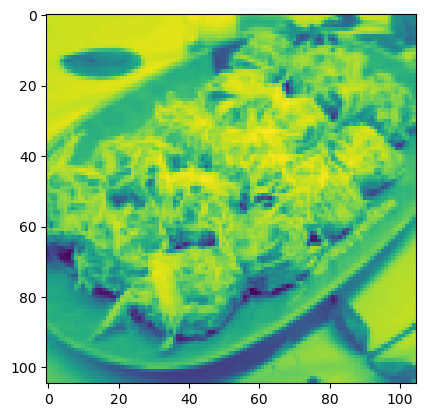

Support set


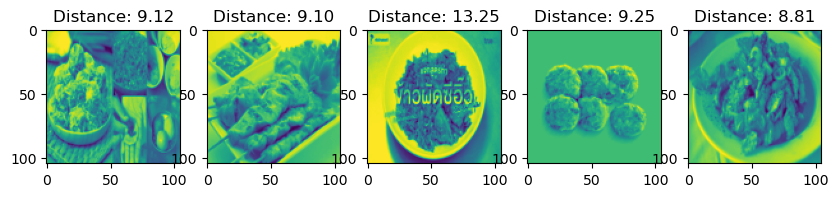

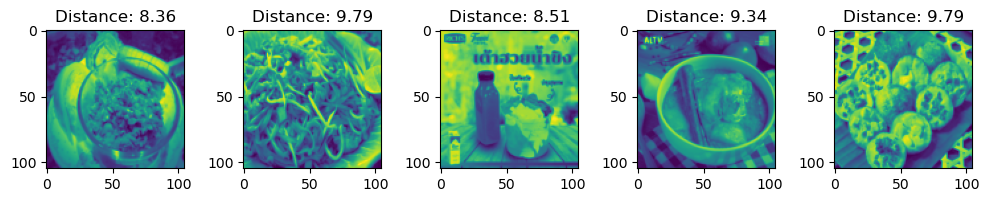

In [126]:
input, target = triplet_dl.make_oneshot_task(10)

print('Base image')
plt.imshow(input[0][0].numpy().squeeze(0))
plt.show()

print('Support set')

model.to(device)
model.eval()

for i in range(len(input[1])):
    if i % 5 == 0:
        fig, axs = plt.subplots(1, 5, figsize=(10, 10))
    
    input_image = input[1][i].unsqueeze(0).to(device)
    base_image = input[0][i].unsqueeze(0).to(device)
    
    axs[i % 5].imshow(input[1][i].numpy().squeeze(0))
    distance = model.get_distance(base_image, input_image).item()
    axs[i % 5].set_title(f'Distance: {distance:.2f}')

plt.tight_layout()
plt.show()
